# Interpolate MODFLOW heads onto a raster grid

In [1]:
import sys
import glob
sys.path += glob.glob('/Users/aleaf/Documents/GitHub/*')
from rasterio import Affine
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import flopy
import flopy.utils.binaryfile as bf
from flopy.utils.reference import SpatialReference
from flopy.utils.postprocessing import get_water_table
from GISops import project_raster

% matplotlib inline

#### load heads file

In [2]:
hdsfile = 's4dr10aq1/S4DR10AQ1.HED'
demascii = 'seaclipDEM.asc'

#hdsobj = bf.HeadFile(hdsfile)
hds = np.loadtxt(hdsfile)
hds.shape

(3648, 682)

In [3]:
ncol, nrow, nlay = 682, 912, 4
hds = np.reshape(hds, (nlay, nrow, ncol))

In [4]:
hds.min(), hds.max()

(-999.0, 999.98999000000003)

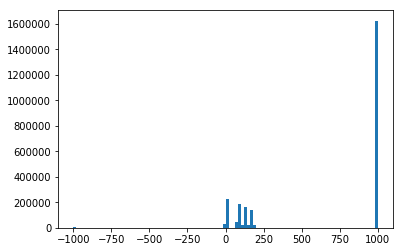

In [5]:
hist = plt.hist(hds.ravel(), bins=100)

In [6]:
hds[hds > 250] = np.nan

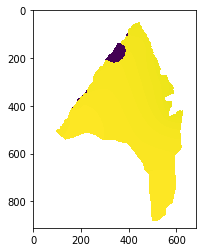

In [7]:
plt.imshow(hds[0, :, :])

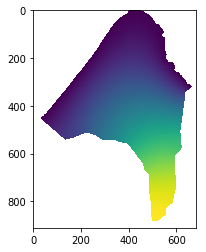

In [8]:
plt.imshow(hds[3, :, :])

In [9]:
fm = flopy.modflow
#fm.Modflow.load('S4DR10AQ1.nam', model_ws='s4dr10aq1')

### set up spatial reference for gw model

In [10]:
xll, yll = -1252846.9726693, 212016.92296668
#epsg = 5070 # apparently not on spatialreference.org
rot = 0.
dxdy = 10
dxdy_m = dxdy*.3048

sr = SpatialReference(delc=np.ones(nrow, dtype=float)*dxdy, 
                            delr=np.ones(ncol, dtype=float)*dxdy, 
                            xll=xll, yll=yll, rotation=rot,
                            length_multiplier=0.3048)

### export arc ascii grids of the heads

In [11]:
for layer, heads in enumerate(hds):
    sr.export_array('heads{}.asc'.format(layer), 
                          heads, fmt='%.2f')

wrote heads0.asc
wrote heads1.asc
wrote heads2.asc
wrote heads3.asc


### read in original ascii-format dem

In [12]:
dem = np.loadtxt(demascii, skiprows=6)

In [13]:
def get_header_info(asciigrid):
    meta = {}
    with open(asciigrid) as input:
        for i in range(6):
            line = next(input).strip().split()
            meta[line[0]] = line[1]
    return meta
meta = get_header_info(demascii)
meta

{'NODATA_value': '-9999.',
 'cellsize': '10',
 'ncols': '682',
 'nrows': '912',
 'xllcorner': '1252846.9726693',
 'yllcorner': '212016.92296668'}

### convert to GeoTiff for resampling

In [14]:
yur = yll + dxdy_m * nrow
trans = Affine(dxdy_m, 0., xll, 0., -dxdy_m, yur)

In [15]:
properties = {'count': 1,
              'crs': '+init=epsg:102348',
              'transform': trans,
              'width': dem.shape[1],
              'height': dem.shape[0],
              'driver': 'GTiff',
              'dtype': np.float64,
              'nodata': float(meta['NODATA_value'])}

In [16]:
with rasterio.open(demascii[:-4] + '.tif', 'w', **properties) as dst:
    dst.write(dem, 1)

In [17]:
help(project_raster)

Help on function project_raster in module GISops:

project_raster(src_raster, dst_raster, dst_crs, resampling=1, resolution=None, num_threads=2, driver='GTiff', extention='tif')
    Reproject a raster from one coordinate system to another using Rasterio
    code from: https://github.com/mapbox/rasterio/blob/master/docs/reproject.rst
    
    Parameters
    ----------
    src_raster : str
        Filename of source raster.
    dst_raster : str
        Filename of reprojected (destination) raster.
    dst_crs : str
        Coordinate system of reprojected raster.
        Examples:
            'EPSG:26715'
    resampling : int (see rasterio source code: https://github.com/mapbox/rasterio/blob/master/rasterio/enums.py)
        nearest = 0
        bilinear = 1
        cubic = 2
        cubic_spline = 3
        lanczos = 4
        average = 5
        mode = 6
        gauss = 7
        max = 8
        min = 9
        med = 10
        q1 = 11
        q3 = 12
    resolution : tuple of floats (l

### Make a new DEM with higher resolution  
(to demonstrate interpolation onto a different grid since the original DEM coincides with the MODFLOW model)  
`project_raster` wraps the `rasterio.warp` module to perform the resampling

In [18]:
project_raster(demascii[:-4] + '.tif', 'newdem.tif', dst_crs='+init=epsg:102348',
               resolution=1.)

reprojecting seaclipDEM.tif...
from:
+ellps=GRS80 +lat_0=47 +lat_1=47.5 +lat_2=48.73333333333333 +lon_0=-120.8333333333333 +no_defs +proj=lcc +towgs84=0,0,0,0,0,0,0 +units=m +x_0=500000 +y_0=0, res: 3.05e+00, 3.05e+00
to:
+init=epsg:102348, res: 1.00e+00, 1.00e+00...


/Users/aleaf/anaconda/envs/gis/lib/python3.6/site-packages/ipykernel/__main__.py:2: DeprecationWarning: 'src.affine' is deprecated.  Please switch to 'src.transform'. See https://github.com/mapbox/rasterio/issues/86 for details.
  from ipykernel import kernelapp as app


wrote newdem.tif.


In [19]:
with rasterio.open('newdem.tif') as src:
    print(src.meta)
    nrow, ncol = src.height, src.width
    newdem = src.read(1)
    meta = src.meta

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': -9999.0, 'width': 2079, 'height': 2780, 'count': 1, 'crs': CRS({'proj': 'lcc', 'lat_1': 47.5, 'lat_2': 48.73333333333333, 'lat_0': 47, 'lon_0': -120.8333333333333, 'x_0': 500000, 'y_0': 0, 'ellps': 'GRS80', 'towgs84': '0,0,0,0,0,0,0', 'units': 'm', 'no_defs': True}), 'transform': Affine(1.0, 0.0, -1252846.972669303,
       0.0, -1.0, 214796.6989666753)}


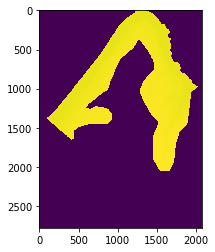

In [20]:
plt.imshow(newdem)

### Get the x, y locations of cells in new raster

In [21]:
src.transform

Affine(1.0, 0.0, -1252846.972669303,
       0.0, -1.0, 214796.6989666753)

In [22]:
x = np.arange(0, src.width) * src.transform[0] + src.transform[2]
y = np.arange(0, src.height) * src.transform[4] + src.transform[5]
x, y = np.meshgrid(x, y)

In [23]:
help(src.xy)

Help on method xy in module rasterio.io:

xy(row, col, offset='center') method of rasterio.io.DatasetReader instance
    Returns the coordinates ``(x, y)`` of a pixel at `row` and `col`.
    The pixel's center is returned by default, but a corner can be returned
    by setting `offset` to one of `ul, ur, ll, lr`.
    
    Parameters
    ----------
    row : int
        Pixel row.
    col : int
        Pixel column.
    offset : str, optional
        Determines if the returned coordinates are for the center of the
        pixel or for a corner.
    
    Returns
    -------
    tuple
        ``(x, y)``



In [24]:
help(sr.interpolate)

Help on method interpolate in module flopy.utils.reference:

interpolate(a, xi, method='nearest') method of flopy.utils.reference.SpatialReference instance
    Use the griddata method to interpolate values from an array onto the
    points defined in xi.  For any values outside of the grid, use
    'nearest' to find a value for them.
    
    Parameters
    ----------
    a : numpy.ndarray
        array to interpolate from.  It must be of size nrow, ncol
    xi : numpy.ndarray
        array containing x and y point coordinates of size (npts, 2). xi
        also works with broadcasting so that if a is a 2d array, then
        xi can be passed in as (xgrid, ygrid).
    method : {'linear', 'nearest', 'cubic'}
        method to use for interpolation (default is 'nearest')
    
    Returns
    -------
    b : numpy.ndarray
        array of size (npts)



### Interpolate head values on to x, y locations of cells in new dem

In [25]:
interp = sr.interpolate(hds[0], (x, y), method='linear')

In [26]:
interp.shape

(2780, 2079)

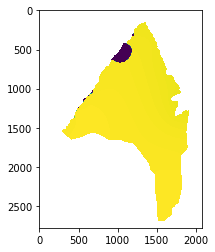

In [27]:
plt.imshow(interp)

In [28]:
with rasterio.open('interp_heads.tif', 'w', **meta) as dst:
    dst.write(interp, 1)